In [40]:
import h5py
import inspect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
from collections import OrderedDict
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
%matplotlib inline

## Inspect Available GPUs

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


In [3]:
print("Cuda is available:", torch.cuda.is_available())
print("Cuda device count:", torch.cuda.device_count())

Cuda is available: True
Cuda device count: 1


## Create Datasets

In [4]:
PATH_TO_TRAIN = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_train_features.hdf5"
PATH_TO_VAL = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_val_features.hdf5"
PATH_TO_TEST = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_test_features.hdf5"

In [5]:
class HDF5Dataset(Dataset):
    
    def __init__(self, hdf5_path: str, transform=None, enable_dlbcl_classification=False):
        self.hdf5_path = hdf5_path
        self.h5data = h5py.File(self.hdf5_path, "r")
        self.cores = list(self.h5data.keys())
        self.transform = transform
        self.enable_dlbcl_classification = False
        
    def __len__(self):
        return len(self.cores)
    
    def __getitem__(self, idx):
        patient_id = self.cores[idx]
        patches = self.h5data[patient_id][()]
        label = self.h5data[patient_id].attrs["y"]
        if self.transform:
            patches = self.transform(patches)
        # Convert to DLBCL vs non-DLBCL classification
        if self.enable_dlbcl_classification:
            if label != 0:
                label = 1
        return torch.tensor(patches), torch.tensor(int(label))

In [6]:
train_dataset = HDF5Dataset(PATH_TO_TRAIN)
val_dataset = HDF5Dataset(PATH_TO_VAL)
test_dataset = HDF5Dataset(PATH_TO_TEST)

## Create Dataloaders

In [7]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

In [8]:
# Output the label distribution in the train_dataloader
label_counts = defaultdict(int)
for (x,y) in train_dataloader:
    label_counts[y.item()] += 1
label_counts

defaultdict(int,
            {1: 131, 0: 370, 6: 59, 3: 59, 7: 43, 4: 75, 5: 21, 2: 10, 8: 4})

## Create Linear Layer Above Feature Extractor

In [9]:
class LinearLayer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(256*3, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LinearLayer(9)

## Define Optimizer and Loss Criterion

In [10]:
# learning_rate = 1e-2
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss() 

## Define Training Loop

In [11]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        i = 0
        for x, y in batches:
            optimizer.zero_grad()
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            loss = criterion(aggregated_scores, y)
            loss.backward()
            optimizer.step()
            _,preds = torch.max(aggregated_scores, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
            i += 1
        print(f"Completed {i} iterations in epoch")
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            loss = criterion(aggregated_scores, y)
            _, preds = torch.max(aggregated_scores, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))

In [13]:
%%time
epochs = 10
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=epochs)

Epoch: 0
Completed 772 iterations in epoch
Epoch: 1 Training Loss: 1.6648 Got 365 / 772 correct. Acc: 47.28%
Epoch: 1 Validation Loss: 1.8957 Got 109 / 276 correct 39.49%
Epoch: 1
Completed 772 iterations in epoch
Epoch: 2 Training Loss: 1.6183 Got 369 / 772 correct. Acc: 47.80%
Epoch: 2 Validation Loss: 1.8775 Got 108 / 276 correct 39.13%
Epoch: 2
Completed 772 iterations in epoch
Epoch: 3 Training Loss: 1.6017 Got 371 / 772 correct. Acc: 48.06%
Epoch: 3 Validation Loss: 1.8584 Got 108 / 276 correct 39.13%
Epoch: 3
Completed 772 iterations in epoch
Epoch: 4 Training Loss: 1.5921 Got 370 / 772 correct. Acc: 47.93%
Epoch: 4 Validation Loss: 1.8689 Got 108 / 276 correct 39.13%
Epoch: 4
Completed 772 iterations in epoch
Epoch: 5 Training Loss: 1.5876 Got 365 / 772 correct. Acc: 47.28%
Epoch: 5 Validation Loss: 1.8792 Got 109 / 276 correct 39.49%
Epoch: 5
Completed 772 iterations in epoch
Epoch: 6 Training Loss: 1.5839 Got 369 / 772 correct. Acc: 47.80%
Epoch: 6 Validation Loss: 1.8547 Got

In [14]:
PATH = "triplenet_model.dat"
torch.save(model, PATH)
print("Successfully saved model!")

Successfully saved model!


In [15]:
# Print out the model parameters after training.
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[ 0.1375,  0.0167,  0.0122,  ...,  0.0294,  0.0137, -0.0559],
        [-0.0428,  0.0590, -0.0069,  ..., -0.0396, -0.0247,  0.1189],
        [-0.2899, -0.1671, -0.1408,  ...,  0.1106, -0.0817,  0.0258],
        ...,
        [-0.2267,  0.0566,  0.0048,  ...,  0.1472,  0.0686,  0.0725],
        [-0.0247, -0.0183, -0.0385,  ...,  0.0482,  0.0052,  0.0714],
        [-0.1188, -0.1355, -0.3509,  ...,  0.0755, -0.2627,  0.0215]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0684, -0.0102, -0.1003, -0.0014, -0.0027, -0.0552, -0.0214, -0.0267,
        -0.1214], device='cuda:0', requires_grad=True)


## Load Saved Model

In [16]:
PATH = "triplenet_model.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model

In [17]:
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss() 

## Resume Training with Loaded Model

In [16]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=2000)

Epoch: 0
Completed 772 iterations in epoch
Epoch: 1 Training Loss: 0.4826 Got 667 / 772 correct. Acc: 86.40%
Epoch: 1 Validation Loss: 3.7299 Got 73 / 276 correct 26.45%
Epoch: 1
Completed 772 iterations in epoch
Epoch: 2 Training Loss: 0.4811 Got 664 / 772 correct. Acc: 86.01%
Epoch: 2 Validation Loss: 3.7186 Got 74 / 276 correct 26.81%
Epoch: 2
Completed 772 iterations in epoch
Epoch: 3 Training Loss: 0.4830 Got 662 / 772 correct. Acc: 85.75%
Epoch: 3 Validation Loss: 3.7564 Got 72 / 276 correct 26.09%
Epoch: 3
Completed 772 iterations in epoch
Epoch: 4 Training Loss: 0.4825 Got 667 / 772 correct. Acc: 86.40%
Epoch: 4 Validation Loss: 3.7746 Got 77 / 276 correct 27.90%
Epoch: 4
Completed 772 iterations in epoch
Epoch: 5 Training Loss: 0.4801 Got 666 / 772 correct. Acc: 86.27%
Epoch: 5 Validation Loss: 3.7528 Got 71 / 276 correct 25.72%
Epoch: 5
Completed 772 iterations in epoch
Epoch: 6 Training Loss: 0.4855 Got 667 / 772 correct. Acc: 86.40%
Epoch: 6 Validation Loss: 3.7640 Got 73 /

Epoch: 48 Validation Loss: 3.8001 Got 76 / 276 correct 27.54%
Epoch: 48
Completed 772 iterations in epoch
Epoch: 49 Training Loss: 0.4765 Got 672 / 772 correct. Acc: 87.05%
Epoch: 49 Validation Loss: 3.7699 Got 73 / 276 correct 26.45%
Epoch: 49
Completed 772 iterations in epoch
Epoch: 50 Training Loss: 0.4806 Got 658 / 772 correct. Acc: 85.23%
Epoch: 50 Validation Loss: 3.7860 Got 77 / 276 correct 27.90%
Epoch: 50
Completed 772 iterations in epoch
Epoch: 51 Training Loss: 0.4799 Got 666 / 772 correct. Acc: 86.27%
Epoch: 51 Validation Loss: 3.7610 Got 71 / 276 correct 25.72%
Epoch: 51
Completed 772 iterations in epoch
Epoch: 52 Training Loss: 0.4779 Got 672 / 772 correct. Acc: 87.05%
Epoch: 52 Validation Loss: 3.7525 Got 76 / 276 correct 27.54%
Epoch: 52
Completed 772 iterations in epoch
Epoch: 53 Training Loss: 0.4802 Got 662 / 772 correct. Acc: 85.75%
Epoch: 53 Validation Loss: 3.7552 Got 77 / 276 correct 27.90%
Epoch: 53
Completed 772 iterations in epoch
Epoch: 54 Training Loss: 0.48

Completed 772 iterations in epoch
Epoch: 96 Training Loss: 0.4765 Got 680 / 772 correct. Acc: 88.08%
Epoch: 96 Validation Loss: 3.8199 Got 75 / 276 correct 27.17%
Epoch: 96
Completed 772 iterations in epoch
Epoch: 97 Training Loss: 0.4793 Got 672 / 772 correct. Acc: 87.05%
Epoch: 97 Validation Loss: 3.8100 Got 77 / 276 correct 27.90%
Epoch: 97
Completed 772 iterations in epoch
Epoch: 98 Training Loss: 0.4789 Got 666 / 772 correct. Acc: 86.27%
Epoch: 98 Validation Loss: 3.7718 Got 71 / 276 correct 25.72%
Epoch: 98
Completed 772 iterations in epoch
Epoch: 99 Training Loss: 0.4776 Got 671 / 772 correct. Acc: 86.92%
Epoch: 99 Validation Loss: 3.8360 Got 81 / 276 correct 29.35%
Epoch: 99
Completed 772 iterations in epoch
Epoch: 100 Training Loss: 0.4772 Got 666 / 772 correct. Acc: 86.27%
Epoch: 100 Validation Loss: 3.7600 Got 70 / 276 correct 25.36%
Epoch: 100
Completed 772 iterations in epoch
Epoch: 101 Training Loss: 0.4772 Got 672 / 772 correct. Acc: 87.05%
Epoch: 101 Validation Loss: 3.

Completed 772 iterations in epoch
Epoch: 143 Training Loss: 0.4773 Got 670 / 772 correct. Acc: 86.79%
Epoch: 143 Validation Loss: 3.8136 Got 76 / 276 correct 27.54%
Epoch: 143
Completed 772 iterations in epoch
Epoch: 144 Training Loss: 0.4726 Got 676 / 772 correct. Acc: 87.56%
Epoch: 144 Validation Loss: 3.7733 Got 74 / 276 correct 26.81%
Epoch: 144
Completed 772 iterations in epoch
Epoch: 145 Training Loss: 0.4734 Got 674 / 772 correct. Acc: 87.31%
Epoch: 145 Validation Loss: 3.8542 Got 78 / 276 correct 28.26%
Epoch: 145
Completed 772 iterations in epoch
Epoch: 146 Training Loss: 0.4738 Got 666 / 772 correct. Acc: 86.27%
Epoch: 146 Validation Loss: 3.8648 Got 81 / 276 correct 29.35%
Epoch: 146
Completed 772 iterations in epoch
Epoch: 147 Training Loss: 0.4769 Got 667 / 772 correct. Acc: 86.40%
Epoch: 147 Validation Loss: 3.8009 Got 73 / 276 correct 26.45%
Epoch: 147
Completed 772 iterations in epoch
Epoch: 148 Training Loss: 0.4755 Got 666 / 772 correct. Acc: 86.27%
Epoch: 148 Validat

Epoch: 189 Validation Loss: 3.8441 Got 76 / 276 correct 27.54%
Epoch: 189
Completed 772 iterations in epoch
Epoch: 190 Training Loss: 0.4756 Got 664 / 772 correct. Acc: 86.01%
Epoch: 190 Validation Loss: 3.8309 Got 76 / 276 correct 27.54%
Epoch: 190
Completed 772 iterations in epoch
Epoch: 191 Training Loss: 0.4692 Got 674 / 772 correct. Acc: 87.31%
Epoch: 191 Validation Loss: 3.8195 Got 72 / 276 correct 26.09%
Epoch: 191
Completed 772 iterations in epoch
Epoch: 192 Training Loss: 0.4727 Got 668 / 772 correct. Acc: 86.53%
Epoch: 192 Validation Loss: 3.8157 Got 76 / 276 correct 27.54%
Epoch: 192
Completed 772 iterations in epoch
Epoch: 193 Training Loss: 0.4725 Got 664 / 772 correct. Acc: 86.01%
Epoch: 193 Validation Loss: 3.8261 Got 76 / 276 correct 27.54%
Epoch: 193
Completed 772 iterations in epoch
Epoch: 194 Training Loss: 0.4711 Got 676 / 772 correct. Acc: 87.56%
Epoch: 194 Validation Loss: 3.8846 Got 81 / 276 correct 29.35%
Epoch: 194
Completed 772 iterations in epoch
Epoch: 195 T

Epoch: 236 Validation Loss: 3.8639 Got 79 / 276 correct 28.62%
Epoch: 236
Completed 772 iterations in epoch
Epoch: 237 Training Loss: 0.4696 Got 669 / 772 correct. Acc: 86.66%
Epoch: 237 Validation Loss: 3.8296 Got 72 / 276 correct 26.09%
Epoch: 237
Completed 772 iterations in epoch
Epoch: 238 Training Loss: 0.4698 Got 670 / 772 correct. Acc: 86.79%
Epoch: 238 Validation Loss: 3.8512 Got 75 / 276 correct 27.17%
Epoch: 238
Completed 772 iterations in epoch
Epoch: 239 Training Loss: 0.4710 Got 665 / 772 correct. Acc: 86.14%
Epoch: 239 Validation Loss: 3.8336 Got 76 / 276 correct 27.54%
Epoch: 239
Completed 772 iterations in epoch
Epoch: 240 Training Loss: 0.4698 Got 669 / 772 correct. Acc: 86.66%
Epoch: 240 Validation Loss: 3.8576 Got 77 / 276 correct 27.90%
Epoch: 240
Completed 772 iterations in epoch
Epoch: 241 Training Loss: 0.4741 Got 670 / 772 correct. Acc: 86.79%
Epoch: 241 Validation Loss: 3.8500 Got 77 / 276 correct 27.90%
Epoch: 241
Completed 772 iterations in epoch
Epoch: 242 T

Epoch: 283 Validation Loss: 3.9007 Got 79 / 276 correct 28.62%
Epoch: 283
Completed 772 iterations in epoch
Epoch: 284 Training Loss: 0.4690 Got 675 / 772 correct. Acc: 87.44%
Epoch: 284 Validation Loss: 3.8701 Got 77 / 276 correct 27.90%
Epoch: 284
Completed 772 iterations in epoch
Epoch: 285 Training Loss: 0.4690 Got 671 / 772 correct. Acc: 86.92%
Epoch: 285 Validation Loss: 3.8629 Got 76 / 276 correct 27.54%
Epoch: 285
Completed 772 iterations in epoch
Epoch: 286 Training Loss: 0.4682 Got 675 / 772 correct. Acc: 87.44%
Epoch: 286 Validation Loss: 3.8625 Got 71 / 276 correct 25.72%
Epoch: 286
Completed 772 iterations in epoch
Epoch: 287 Training Loss: 0.4729 Got 666 / 772 correct. Acc: 86.27%
Epoch: 287 Validation Loss: 3.8360 Got 73 / 276 correct 26.45%
Epoch: 287
Completed 772 iterations in epoch
Epoch: 288 Training Loss: 0.4700 Got 666 / 772 correct. Acc: 86.27%
Epoch: 288 Validation Loss: 3.8276 Got 77 / 276 correct 27.90%
Epoch: 288
Completed 772 iterations in epoch
Epoch: 289 T

Epoch: 330 Validation Loss: 3.8384 Got 72 / 276 correct 26.09%
Epoch: 330
Completed 772 iterations in epoch
Epoch: 331 Training Loss: 0.4681 Got 675 / 772 correct. Acc: 87.44%
Epoch: 331 Validation Loss: 3.8791 Got 76 / 276 correct 27.54%
Epoch: 331
Completed 772 iterations in epoch
Epoch: 332 Training Loss: 0.4662 Got 668 / 772 correct. Acc: 86.53%
Epoch: 332 Validation Loss: 3.8526 Got 74 / 276 correct 26.81%
Epoch: 332
Completed 772 iterations in epoch
Epoch: 333 Training Loss: 0.4654 Got 669 / 772 correct. Acc: 86.66%
Epoch: 333 Validation Loss: 3.8674 Got 74 / 276 correct 26.81%
Epoch: 333
Completed 772 iterations in epoch
Epoch: 334 Training Loss: 0.4664 Got 673 / 772 correct. Acc: 87.18%
Epoch: 334 Validation Loss: 3.8847 Got 72 / 276 correct 26.09%
Epoch: 334
Completed 772 iterations in epoch
Epoch: 335 Training Loss: 0.4673 Got 674 / 772 correct. Acc: 87.31%
Epoch: 335 Validation Loss: 3.8766 Got 75 / 276 correct 27.17%
Epoch: 335
Completed 772 iterations in epoch
Epoch: 336 T

Epoch: 377 Validation Loss: 3.8720 Got 74 / 276 correct 26.81%
Epoch: 377
Completed 772 iterations in epoch
Epoch: 378 Training Loss: 0.4636 Got 671 / 772 correct. Acc: 86.92%
Epoch: 378 Validation Loss: 3.8841 Got 80 / 276 correct 28.99%
Epoch: 378
Completed 772 iterations in epoch
Epoch: 379 Training Loss: 0.4628 Got 670 / 772 correct. Acc: 86.79%
Epoch: 379 Validation Loss: 3.9125 Got 79 / 276 correct 28.62%
Epoch: 379
Completed 772 iterations in epoch
Epoch: 380 Training Loss: 0.4632 Got 672 / 772 correct. Acc: 87.05%
Epoch: 380 Validation Loss: 3.9276 Got 78 / 276 correct 28.26%
Epoch: 380
Completed 772 iterations in epoch
Epoch: 381 Training Loss: 0.4642 Got 676 / 772 correct. Acc: 87.56%
Epoch: 381 Validation Loss: 3.9252 Got 77 / 276 correct 27.90%
Epoch: 381
Completed 772 iterations in epoch
Epoch: 382 Training Loss: 0.4636 Got 672 / 772 correct. Acc: 87.05%
Epoch: 382 Validation Loss: 3.9376 Got 80 / 276 correct 28.99%
Epoch: 382
Completed 772 iterations in epoch
Epoch: 383 T

Epoch: 424 Validation Loss: 3.8800 Got 71 / 276 correct 25.72%
Epoch: 424
Completed 772 iterations in epoch
Epoch: 425 Training Loss: 0.4615 Got 673 / 772 correct. Acc: 87.18%
Epoch: 425 Validation Loss: 3.9091 Got 74 / 276 correct 26.81%
Epoch: 425
Completed 772 iterations in epoch
Epoch: 426 Training Loss: 0.4616 Got 671 / 772 correct. Acc: 86.92%
Epoch: 426 Validation Loss: 3.8604 Got 72 / 276 correct 26.09%
Epoch: 426
Completed 772 iterations in epoch
Epoch: 427 Training Loss: 0.4611 Got 683 / 772 correct. Acc: 88.47%
Epoch: 427 Validation Loss: 3.9662 Got 79 / 276 correct 28.62%
Epoch: 427
Completed 772 iterations in epoch
Epoch: 428 Training Loss: 0.4630 Got 664 / 772 correct. Acc: 86.01%
Epoch: 428 Validation Loss: 3.8770 Got 72 / 276 correct 26.09%
Epoch: 428
Completed 772 iterations in epoch
Epoch: 429 Training Loss: 0.4613 Got 673 / 772 correct. Acc: 87.18%
Epoch: 429 Validation Loss: 3.9995 Got 81 / 276 correct 29.35%
Epoch: 429
Completed 772 iterations in epoch
Epoch: 430 T

Epoch: 471 Validation Loss: 3.9015 Got 67 / 276 correct 24.28%
Epoch: 471
Completed 772 iterations in epoch
Epoch: 472 Training Loss: 0.4619 Got 669 / 772 correct. Acc: 86.66%
Epoch: 472 Validation Loss: 3.9287 Got 76 / 276 correct 27.54%
Epoch: 472
Completed 772 iterations in epoch
Epoch: 473 Training Loss: 0.4601 Got 674 / 772 correct. Acc: 87.31%
Epoch: 473 Validation Loss: 3.9258 Got 77 / 276 correct 27.90%
Epoch: 473
Completed 772 iterations in epoch
Epoch: 474 Training Loss: 0.4583 Got 677 / 772 correct. Acc: 87.69%
Epoch: 474 Validation Loss: 3.8811 Got 74 / 276 correct 26.81%
Epoch: 474
Completed 772 iterations in epoch
Epoch: 475 Training Loss: 0.4589 Got 671 / 772 correct. Acc: 86.92%
Epoch: 475 Validation Loss: 3.9485 Got 80 / 276 correct 28.99%
Epoch: 475
Completed 772 iterations in epoch
Epoch: 476 Training Loss: 0.4614 Got 671 / 772 correct. Acc: 86.92%
Epoch: 476 Validation Loss: 3.9072 Got 73 / 276 correct 26.45%
Epoch: 476
Completed 772 iterations in epoch
Epoch: 477 T

Epoch: 518 Validation Loss: 4.0078 Got 77 / 276 correct 27.90%
Epoch: 518
Completed 772 iterations in epoch
Epoch: 519 Training Loss: 0.4589 Got 669 / 772 correct. Acc: 86.66%
Epoch: 519 Validation Loss: 3.9053 Got 72 / 276 correct 26.09%
Epoch: 519
Completed 772 iterations in epoch
Epoch: 520 Training Loss: 0.4587 Got 671 / 772 correct. Acc: 86.92%
Epoch: 520 Validation Loss: 3.9502 Got 79 / 276 correct 28.62%
Epoch: 520
Completed 772 iterations in epoch
Epoch: 521 Training Loss: 0.4580 Got 679 / 772 correct. Acc: 87.95%
Epoch: 521 Validation Loss: 3.9247 Got 75 / 276 correct 27.17%
Epoch: 521
Completed 772 iterations in epoch
Epoch: 522 Training Loss: 0.4562 Got 683 / 772 correct. Acc: 88.47%
Epoch: 522 Validation Loss: 3.9622 Got 78 / 276 correct 28.26%
Epoch: 522
Completed 772 iterations in epoch
Epoch: 523 Training Loss: 0.4564 Got 673 / 772 correct. Acc: 87.18%
Epoch: 523 Validation Loss: 3.9158 Got 73 / 276 correct 26.45%
Epoch: 523
Completed 772 iterations in epoch
Epoch: 524 T

Epoch: 565 Validation Loss: 3.9384 Got 74 / 276 correct 26.81%
Epoch: 565
Completed 772 iterations in epoch
Epoch: 566 Training Loss: 0.4548 Got 678 / 772 correct. Acc: 87.82%
Epoch: 566 Validation Loss: 3.8903 Got 72 / 276 correct 26.09%
Epoch: 566
Completed 772 iterations in epoch
Epoch: 567 Training Loss: 0.4595 Got 671 / 772 correct. Acc: 86.92%
Epoch: 567 Validation Loss: 3.8986 Got 73 / 276 correct 26.45%
Epoch: 567
Completed 772 iterations in epoch
Epoch: 568 Training Loss: 0.4573 Got 674 / 772 correct. Acc: 87.31%
Epoch: 568 Validation Loss: 3.9326 Got 72 / 276 correct 26.09%
Epoch: 568
Completed 772 iterations in epoch
Epoch: 569 Training Loss: 0.4543 Got 671 / 772 correct. Acc: 86.92%
Epoch: 569 Validation Loss: 3.9218 Got 75 / 276 correct 27.17%
Epoch: 569
Completed 772 iterations in epoch
Epoch: 570 Training Loss: 0.4548 Got 671 / 772 correct. Acc: 86.92%
Epoch: 570 Validation Loss: 3.9440 Got 73 / 276 correct 26.45%
Epoch: 570
Completed 772 iterations in epoch
Epoch: 571 T

Epoch: 612 Validation Loss: 3.9129 Got 75 / 276 correct 27.17%
Epoch: 612
Completed 772 iterations in epoch
Epoch: 613 Training Loss: 0.4539 Got 674 / 772 correct. Acc: 87.31%
Epoch: 613 Validation Loss: 3.9460 Got 76 / 276 correct 27.54%
Epoch: 613
Completed 772 iterations in epoch
Epoch: 614 Training Loss: 0.4559 Got 683 / 772 correct. Acc: 88.47%
Epoch: 614 Validation Loss: 3.9336 Got 72 / 276 correct 26.09%
Epoch: 614
Completed 772 iterations in epoch
Epoch: 615 Training Loss: 0.4553 Got 676 / 772 correct. Acc: 87.56%
Epoch: 615 Validation Loss: 3.9155 Got 74 / 276 correct 26.81%
Epoch: 615
Completed 772 iterations in epoch
Epoch: 616 Training Loss: 0.4541 Got 673 / 772 correct. Acc: 87.18%
Epoch: 616 Validation Loss: 3.9399 Got 76 / 276 correct 27.54%
Epoch: 616
Completed 772 iterations in epoch
Epoch: 617 Training Loss: 0.4583 Got 668 / 772 correct. Acc: 86.53%
Epoch: 617 Validation Loss: 3.9264 Got 72 / 276 correct 26.09%
Epoch: 617
Completed 772 iterations in epoch
Epoch: 618 T

Epoch: 659 Validation Loss: 3.9564 Got 71 / 276 correct 25.72%
Epoch: 659
Completed 772 iterations in epoch
Epoch: 660 Training Loss: 0.4528 Got 677 / 772 correct. Acc: 87.69%
Epoch: 660 Validation Loss: 3.9265 Got 71 / 276 correct 25.72%
Epoch: 660
Completed 772 iterations in epoch
Epoch: 661 Training Loss: 0.4534 Got 680 / 772 correct. Acc: 88.08%
Epoch: 661 Validation Loss: 3.9553 Got 76 / 276 correct 27.54%
Epoch: 661
Completed 772 iterations in epoch
Epoch: 662 Training Loss: 0.4516 Got 679 / 772 correct. Acc: 87.95%
Epoch: 662 Validation Loss: 3.9529 Got 73 / 276 correct 26.45%
Epoch: 662
Completed 772 iterations in epoch
Epoch: 663 Training Loss: 0.4513 Got 676 / 772 correct. Acc: 87.56%
Epoch: 663 Validation Loss: 3.9377 Got 74 / 276 correct 26.81%
Epoch: 663
Completed 772 iterations in epoch
Epoch: 664 Training Loss: 0.4518 Got 672 / 772 correct. Acc: 87.05%
Epoch: 664 Validation Loss: 3.9472 Got 76 / 276 correct 27.54%
Epoch: 664
Completed 772 iterations in epoch
Epoch: 665 T

Epoch: 706 Validation Loss: 3.9636 Got 75 / 276 correct 27.17%
Epoch: 706
Completed 772 iterations in epoch
Epoch: 707 Training Loss: 0.4507 Got 675 / 772 correct. Acc: 87.44%
Epoch: 707 Validation Loss: 3.9897 Got 78 / 276 correct 28.26%
Epoch: 707
Completed 772 iterations in epoch
Epoch: 708 Training Loss: 0.4507 Got 680 / 772 correct. Acc: 88.08%
Epoch: 708 Validation Loss: 4.0063 Got 76 / 276 correct 27.54%
Epoch: 708
Completed 772 iterations in epoch
Epoch: 709 Training Loss: 0.4500 Got 681 / 772 correct. Acc: 88.21%
Epoch: 709 Validation Loss: 3.9858 Got 74 / 276 correct 26.81%
Epoch: 709
Completed 772 iterations in epoch
Epoch: 710 Training Loss: 0.4528 Got 671 / 772 correct. Acc: 86.92%
Epoch: 710 Validation Loss: 3.9526 Got 74 / 276 correct 26.81%
Epoch: 710
Completed 772 iterations in epoch
Epoch: 711 Training Loss: 0.4512 Got 675 / 772 correct. Acc: 87.44%
Epoch: 711 Validation Loss: 3.9711 Got 76 / 276 correct 27.54%
Epoch: 711
Completed 772 iterations in epoch
Epoch: 712 T

Epoch: 753 Validation Loss: 4.0041 Got 74 / 276 correct 26.81%
Epoch: 753
Completed 772 iterations in epoch
Epoch: 754 Training Loss: 0.4477 Got 677 / 772 correct. Acc: 87.69%
Epoch: 754 Validation Loss: 4.0307 Got 77 / 276 correct 27.90%
Epoch: 754
Completed 772 iterations in epoch
Epoch: 755 Training Loss: 0.4514 Got 677 / 772 correct. Acc: 87.69%
Epoch: 755 Validation Loss: 3.9748 Got 74 / 276 correct 26.81%
Epoch: 755
Completed 772 iterations in epoch
Epoch: 756 Training Loss: 0.4490 Got 676 / 772 correct. Acc: 87.56%
Epoch: 756 Validation Loss: 3.9812 Got 73 / 276 correct 26.45%
Epoch: 756
Completed 772 iterations in epoch
Epoch: 757 Training Loss: 0.4514 Got 678 / 772 correct. Acc: 87.82%
Epoch: 757 Validation Loss: 3.9812 Got 73 / 276 correct 26.45%
Epoch: 757
Completed 772 iterations in epoch
Epoch: 758 Training Loss: 0.4486 Got 671 / 772 correct. Acc: 86.92%
Epoch: 758 Validation Loss: 3.9327 Got 73 / 276 correct 26.45%
Epoch: 758
Completed 772 iterations in epoch
Epoch: 759 T

Epoch: 800 Validation Loss: 4.0251 Got 79 / 276 correct 28.62%
Epoch: 800
Completed 772 iterations in epoch
Epoch: 801 Training Loss: 0.4475 Got 679 / 772 correct. Acc: 87.95%
Epoch: 801 Validation Loss: 3.9980 Got 74 / 276 correct 26.81%
Epoch: 801
Completed 772 iterations in epoch
Epoch: 802 Training Loss: 0.4457 Got 682 / 772 correct. Acc: 88.34%
Epoch: 802 Validation Loss: 3.9700 Got 76 / 276 correct 27.54%
Epoch: 802
Completed 772 iterations in epoch
Epoch: 803 Training Loss: 0.4469 Got 686 / 772 correct. Acc: 88.86%
Epoch: 803 Validation Loss: 3.9995 Got 75 / 276 correct 27.17%
Epoch: 803
Completed 772 iterations in epoch
Epoch: 804 Training Loss: 0.4492 Got 667 / 772 correct. Acc: 86.40%
Epoch: 804 Validation Loss: 4.0097 Got 72 / 276 correct 26.09%
Epoch: 804
Completed 772 iterations in epoch
Epoch: 805 Training Loss: 0.4464 Got 680 / 772 correct. Acc: 88.08%
Epoch: 805 Validation Loss: 4.0011 Got 73 / 276 correct 26.45%
Epoch: 805
Completed 772 iterations in epoch
Epoch: 806 T

Epoch: 847 Validation Loss: 4.0775 Got 77 / 276 correct 27.90%
Epoch: 847
Completed 772 iterations in epoch
Epoch: 848 Training Loss: 0.4490 Got 682 / 772 correct. Acc: 88.34%
Epoch: 848 Validation Loss: 4.0183 Got 76 / 276 correct 27.54%
Epoch: 848
Completed 772 iterations in epoch
Epoch: 849 Training Loss: 0.4438 Got 683 / 772 correct. Acc: 88.47%
Epoch: 849 Validation Loss: 3.9739 Got 73 / 276 correct 26.45%
Epoch: 849
Completed 772 iterations in epoch
Epoch: 850 Training Loss: 0.4459 Got 670 / 772 correct. Acc: 86.79%
Epoch: 850 Validation Loss: 4.0169 Got 76 / 276 correct 27.54%
Epoch: 850
Completed 772 iterations in epoch
Epoch: 851 Training Loss: 0.4432 Got 679 / 772 correct. Acc: 87.95%
Epoch: 851 Validation Loss: 4.0440 Got 79 / 276 correct 28.62%
Epoch: 851
Completed 772 iterations in epoch
Epoch: 852 Training Loss: 0.4422 Got 680 / 772 correct. Acc: 88.08%
Epoch: 852 Validation Loss: 3.9965 Got 74 / 276 correct 26.81%
Epoch: 852
Completed 772 iterations in epoch
Epoch: 853 T

Epoch: 894 Validation Loss: 3.9733 Got 74 / 276 correct 26.81%
Epoch: 894
Completed 772 iterations in epoch
Epoch: 895 Training Loss: 0.4414 Got 678 / 772 correct. Acc: 87.82%
Epoch: 895 Validation Loss: 4.0597 Got 77 / 276 correct 27.90%
Epoch: 895
Completed 772 iterations in epoch
Epoch: 896 Training Loss: 0.4423 Got 674 / 772 correct. Acc: 87.31%
Epoch: 896 Validation Loss: 4.0034 Got 74 / 276 correct 26.81%
Epoch: 896
Completed 772 iterations in epoch
Epoch: 897 Training Loss: 0.4441 Got 681 / 772 correct. Acc: 88.21%
Epoch: 897 Validation Loss: 4.0197 Got 74 / 276 correct 26.81%
Epoch: 897
Completed 772 iterations in epoch
Epoch: 898 Training Loss: 0.4426 Got 678 / 772 correct. Acc: 87.82%
Epoch: 898 Validation Loss: 4.0135 Got 73 / 276 correct 26.45%
Epoch: 898
Completed 772 iterations in epoch
Epoch: 899 Training Loss: 0.4412 Got 680 / 772 correct. Acc: 88.08%
Epoch: 899 Validation Loss: 4.0008 Got 74 / 276 correct 26.81%
Epoch: 899
Completed 772 iterations in epoch
Epoch: 900 T

Epoch: 941 Validation Loss: 4.0933 Got 80 / 276 correct 28.99%
Epoch: 941
Completed 772 iterations in epoch
Epoch: 942 Training Loss: 0.4399 Got 682 / 772 correct. Acc: 88.34%
Epoch: 942 Validation Loss: 4.0150 Got 73 / 276 correct 26.45%
Epoch: 942
Completed 772 iterations in epoch
Epoch: 943 Training Loss: 0.4418 Got 681 / 772 correct. Acc: 88.21%
Epoch: 943 Validation Loss: 4.0539 Got 81 / 276 correct 29.35%
Epoch: 943
Completed 772 iterations in epoch
Epoch: 944 Training Loss: 0.4404 Got 680 / 772 correct. Acc: 88.08%
Epoch: 944 Validation Loss: 4.0293 Got 77 / 276 correct 27.90%
Epoch: 944
Completed 772 iterations in epoch
Epoch: 945 Training Loss: 0.4403 Got 681 / 772 correct. Acc: 88.21%
Epoch: 945 Validation Loss: 4.0751 Got 78 / 276 correct 28.26%
Epoch: 945
Completed 772 iterations in epoch
Epoch: 946 Training Loss: 0.4416 Got 678 / 772 correct. Acc: 87.82%
Epoch: 946 Validation Loss: 4.0256 Got 73 / 276 correct 26.45%
Epoch: 946
Completed 772 iterations in epoch
Epoch: 947 T

Epoch: 988 Validation Loss: 4.0854 Got 77 / 276 correct 27.90%
Epoch: 988
Completed 772 iterations in epoch
Epoch: 989 Training Loss: 0.4403 Got 677 / 772 correct. Acc: 87.69%
Epoch: 989 Validation Loss: 4.0941 Got 78 / 276 correct 28.26%
Epoch: 989
Completed 772 iterations in epoch
Epoch: 990 Training Loss: 0.4420 Got 673 / 772 correct. Acc: 87.18%
Epoch: 990 Validation Loss: 4.1153 Got 79 / 276 correct 28.62%
Epoch: 990
Completed 772 iterations in epoch
Epoch: 991 Training Loss: 0.4401 Got 675 / 772 correct. Acc: 87.44%
Epoch: 991 Validation Loss: 4.0624 Got 76 / 276 correct 27.54%
Epoch: 991
Completed 772 iterations in epoch
Epoch: 992 Training Loss: 0.4407 Got 678 / 772 correct. Acc: 87.82%
Epoch: 992 Validation Loss: 4.0841 Got 75 / 276 correct 27.17%
Epoch: 992
Completed 772 iterations in epoch
Epoch: 993 Training Loss: 0.4410 Got 679 / 772 correct. Acc: 87.95%
Epoch: 993 Validation Loss: 4.0616 Got 72 / 276 correct 26.09%
Epoch: 993
Completed 772 iterations in epoch
Epoch: 994 T

Epoch: 1034 Validation Loss: 4.0446 Got 73 / 276 correct 26.45%
Epoch: 1034
Completed 772 iterations in epoch
Epoch: 1035 Training Loss: 0.4380 Got 676 / 772 correct. Acc: 87.56%
Epoch: 1035 Validation Loss: 4.0877 Got 75 / 276 correct 27.17%
Epoch: 1035
Completed 772 iterations in epoch
Epoch: 1036 Training Loss: 0.4390 Got 678 / 772 correct. Acc: 87.82%
Epoch: 1036 Validation Loss: 4.0970 Got 75 / 276 correct 27.17%
Epoch: 1036
Completed 772 iterations in epoch
Epoch: 1037 Training Loss: 0.4376 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1037 Validation Loss: 4.0654 Got 77 / 276 correct 27.90%
Epoch: 1037
Completed 772 iterations in epoch
Epoch: 1038 Training Loss: 0.4375 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1038 Validation Loss: 4.1030 Got 74 / 276 correct 26.81%
Epoch: 1038
Completed 772 iterations in epoch
Epoch: 1039 Training Loss: 0.4359 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1039 Validation Loss: 4.0216 Got 72 / 276 correct 26.09%
Epoch: 1039
Completed 772 iterations in e

Epoch: 1080 Validation Loss: 4.0824 Got 76 / 276 correct 27.54%
Epoch: 1080
Completed 772 iterations in epoch
Epoch: 1081 Training Loss: 0.4363 Got 679 / 772 correct. Acc: 87.95%
Epoch: 1081 Validation Loss: 4.1118 Got 78 / 276 correct 28.26%
Epoch: 1081
Completed 772 iterations in epoch
Epoch: 1082 Training Loss: 0.4353 Got 678 / 772 correct. Acc: 87.82%
Epoch: 1082 Validation Loss: 4.0648 Got 70 / 276 correct 25.36%
Epoch: 1082
Completed 772 iterations in epoch
Epoch: 1083 Training Loss: 0.4321 Got 681 / 772 correct. Acc: 88.21%
Epoch: 1083 Validation Loss: 4.0699 Got 74 / 276 correct 26.81%
Epoch: 1083
Completed 772 iterations in epoch
Epoch: 1084 Training Loss: 0.4362 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1084 Validation Loss: 4.0661 Got 73 / 276 correct 26.45%
Epoch: 1084
Completed 772 iterations in epoch
Epoch: 1085 Training Loss: 0.4327 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1085 Validation Loss: 4.0978 Got 79 / 276 correct 28.62%
Epoch: 1085
Completed 772 iterations in e

Epoch: 1126 Validation Loss: 4.0846 Got 72 / 276 correct 26.09%
Epoch: 1126
Completed 772 iterations in epoch
Epoch: 1127 Training Loss: 0.4342 Got 676 / 772 correct. Acc: 87.56%
Epoch: 1127 Validation Loss: 4.0669 Got 73 / 276 correct 26.45%
Epoch: 1127
Completed 772 iterations in epoch
Epoch: 1128 Training Loss: 0.4333 Got 681 / 772 correct. Acc: 88.21%
Epoch: 1128 Validation Loss: 4.0795 Got 76 / 276 correct 27.54%
Epoch: 1128
Completed 772 iterations in epoch
Epoch: 1129 Training Loss: 0.4324 Got 679 / 772 correct. Acc: 87.95%
Epoch: 1129 Validation Loss: 4.0545 Got 73 / 276 correct 26.45%
Epoch: 1129
Completed 772 iterations in epoch
Epoch: 1130 Training Loss: 0.4351 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1130 Validation Loss: 4.0515 Got 73 / 276 correct 26.45%
Epoch: 1130
Completed 772 iterations in epoch
Epoch: 1131 Training Loss: 0.4328 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1131 Validation Loss: 4.1202 Got 75 / 276 correct 27.17%
Epoch: 1131
Completed 772 iterations in e

Epoch: 1172 Validation Loss: 4.0991 Got 77 / 276 correct 27.90%
Epoch: 1172
Completed 772 iterations in epoch
Epoch: 1173 Training Loss: 0.4300 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1173 Validation Loss: 4.0856 Got 72 / 276 correct 26.09%
Epoch: 1173
Completed 772 iterations in epoch
Epoch: 1174 Training Loss: 0.4302 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1174 Validation Loss: 4.1163 Got 75 / 276 correct 27.17%
Epoch: 1174
Completed 772 iterations in epoch
Epoch: 1175 Training Loss: 0.4320 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1175 Validation Loss: 4.0849 Got 74 / 276 correct 26.81%
Epoch: 1175
Completed 772 iterations in epoch
Epoch: 1176 Training Loss: 0.4304 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1176 Validation Loss: 4.0864 Got 72 / 276 correct 26.09%
Epoch: 1176
Completed 772 iterations in epoch
Epoch: 1177 Training Loss: 0.4308 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1177 Validation Loss: 4.1317 Got 75 / 276 correct 27.17%
Epoch: 1177
Completed 772 iterations in e

Epoch: 1218 Validation Loss: 4.1202 Got 73 / 276 correct 26.45%
Epoch: 1218
Completed 772 iterations in epoch
Epoch: 1219 Training Loss: 0.4277 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1219 Validation Loss: 4.1863 Got 80 / 276 correct 28.99%
Epoch: 1219
Completed 772 iterations in epoch
Epoch: 1220 Training Loss: 0.4322 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1220 Validation Loss: 4.1434 Got 75 / 276 correct 27.17%
Epoch: 1220
Completed 772 iterations in epoch
Epoch: 1221 Training Loss: 0.4307 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1221 Validation Loss: 4.1688 Got 79 / 276 correct 28.62%
Epoch: 1221
Completed 772 iterations in epoch
Epoch: 1222 Training Loss: 0.4296 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1222 Validation Loss: 4.0991 Got 75 / 276 correct 27.17%
Epoch: 1222
Completed 772 iterations in epoch
Epoch: 1223 Training Loss: 0.4326 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1223 Validation Loss: 4.1323 Got 74 / 276 correct 26.81%
Epoch: 1223
Completed 772 iterations in e

Epoch: 1264 Validation Loss: 4.1311 Got 74 / 276 correct 26.81%
Epoch: 1264
Completed 772 iterations in epoch
Epoch: 1265 Training Loss: 0.4293 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1265 Validation Loss: 4.1643 Got 77 / 276 correct 27.90%
Epoch: 1265
Completed 772 iterations in epoch
Epoch: 1266 Training Loss: 0.4290 Got 678 / 772 correct. Acc: 87.82%
Epoch: 1266 Validation Loss: 4.0968 Got 73 / 276 correct 26.45%
Epoch: 1266
Completed 772 iterations in epoch
Epoch: 1267 Training Loss: 0.4280 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1267 Validation Loss: 4.1468 Got 75 / 276 correct 27.17%
Epoch: 1267
Completed 772 iterations in epoch
Epoch: 1268 Training Loss: 0.4296 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1268 Validation Loss: 4.1393 Got 75 / 276 correct 27.17%
Epoch: 1268
Completed 772 iterations in epoch
Epoch: 1269 Training Loss: 0.4291 Got 678 / 772 correct. Acc: 87.82%
Epoch: 1269 Validation Loss: 4.1367 Got 74 / 276 correct 26.81%
Epoch: 1269
Completed 772 iterations in e

Epoch: 1310 Validation Loss: 4.1278 Got 73 / 276 correct 26.45%
Epoch: 1310
Completed 772 iterations in epoch
Epoch: 1311 Training Loss: 0.4245 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1311 Validation Loss: 4.1852 Got 79 / 276 correct 28.62%
Epoch: 1311
Completed 772 iterations in epoch
Epoch: 1312 Training Loss: 0.4261 Got 678 / 772 correct. Acc: 87.82%
Epoch: 1312 Validation Loss: 4.1497 Got 74 / 276 correct 26.81%
Epoch: 1312
Completed 772 iterations in epoch
Epoch: 1313 Training Loss: 0.4269 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1313 Validation Loss: 4.1689 Got 77 / 276 correct 27.90%
Epoch: 1313
Completed 772 iterations in epoch
Epoch: 1314 Training Loss: 0.4279 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1314 Validation Loss: 4.1888 Got 75 / 276 correct 27.17%
Epoch: 1314
Completed 772 iterations in epoch
Epoch: 1315 Training Loss: 0.4276 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1315 Validation Loss: 4.1419 Got 75 / 276 correct 27.17%
Epoch: 1315
Completed 772 iterations in e

Epoch: 1356 Validation Loss: 4.1716 Got 78 / 276 correct 28.26%
Epoch: 1356
Completed 772 iterations in epoch
Epoch: 1357 Training Loss: 0.4250 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1357 Validation Loss: 4.1478 Got 74 / 276 correct 26.81%
Epoch: 1357
Completed 772 iterations in epoch
Epoch: 1358 Training Loss: 0.4281 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1358 Validation Loss: 4.1686 Got 78 / 276 correct 28.26%
Epoch: 1358
Completed 772 iterations in epoch
Epoch: 1359 Training Loss: 0.4233 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1359 Validation Loss: 4.1479 Got 73 / 276 correct 26.45%
Epoch: 1359
Completed 772 iterations in epoch
Epoch: 1360 Training Loss: 0.4224 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1360 Validation Loss: 4.2087 Got 81 / 276 correct 29.35%
Epoch: 1360
Completed 772 iterations in epoch
Epoch: 1361 Training Loss: 0.4260 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1361 Validation Loss: 4.1273 Got 73 / 276 correct 26.45%
Epoch: 1361
Completed 772 iterations in e

Epoch: 1402 Validation Loss: 4.2103 Got 73 / 276 correct 26.45%
Epoch: 1402
Completed 772 iterations in epoch
Epoch: 1403 Training Loss: 0.4249 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1403 Validation Loss: 4.1759 Got 77 / 276 correct 27.90%
Epoch: 1403
Completed 772 iterations in epoch
Epoch: 1404 Training Loss: 0.4231 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1404 Validation Loss: 4.1827 Got 74 / 276 correct 26.81%
Epoch: 1404
Completed 772 iterations in epoch
Epoch: 1405 Training Loss: 0.4237 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1405 Validation Loss: 4.1420 Got 72 / 276 correct 26.09%
Epoch: 1405
Completed 772 iterations in epoch
Epoch: 1406 Training Loss: 0.4249 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1406 Validation Loss: 4.1298 Got 73 / 276 correct 26.45%
Epoch: 1406
Completed 772 iterations in epoch
Epoch: 1407 Training Loss: 0.4252 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1407 Validation Loss: 4.1572 Got 74 / 276 correct 26.81%
Epoch: 1407
Completed 772 iterations in e

Epoch: 1448 Validation Loss: 4.2149 Got 76 / 276 correct 27.54%
Epoch: 1448
Completed 772 iterations in epoch
Epoch: 1449 Training Loss: 0.4230 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1449 Validation Loss: 4.1950 Got 77 / 276 correct 27.90%
Epoch: 1449
Completed 772 iterations in epoch
Epoch: 1450 Training Loss: 0.4227 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1450 Validation Loss: 4.1783 Got 73 / 276 correct 26.45%
Epoch: 1450
Completed 772 iterations in epoch
Epoch: 1451 Training Loss: 0.4205 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1451 Validation Loss: 4.1943 Got 76 / 276 correct 27.54%
Epoch: 1451
Completed 772 iterations in epoch
Epoch: 1452 Training Loss: 0.4237 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1452 Validation Loss: 4.1836 Got 76 / 276 correct 27.54%
Epoch: 1452
Completed 772 iterations in epoch
Epoch: 1453 Training Loss: 0.4210 Got 692 / 772 correct. Acc: 89.64%
Epoch: 1453 Validation Loss: 4.1814 Got 75 / 276 correct 27.17%
Epoch: 1453
Completed 772 iterations in e

Epoch: 1494 Validation Loss: 4.1964 Got 74 / 276 correct 26.81%
Epoch: 1494
Completed 772 iterations in epoch
Epoch: 1495 Training Loss: 0.4194 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1495 Validation Loss: 4.1648 Got 72 / 276 correct 26.09%
Epoch: 1495
Completed 772 iterations in epoch
Epoch: 1496 Training Loss: 0.4199 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1496 Validation Loss: 4.1599 Got 72 / 276 correct 26.09%
Epoch: 1496
Completed 772 iterations in epoch
Epoch: 1497 Training Loss: 0.4198 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1497 Validation Loss: 4.1569 Got 74 / 276 correct 26.81%
Epoch: 1497
Completed 772 iterations in epoch
Epoch: 1498 Training Loss: 0.4182 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1498 Validation Loss: 4.1789 Got 74 / 276 correct 26.81%
Epoch: 1498
Completed 772 iterations in epoch
Epoch: 1499 Training Loss: 0.4183 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1499 Validation Loss: 4.1983 Got 76 / 276 correct 27.54%
Epoch: 1499
Completed 772 iterations in e

Epoch: 1540 Validation Loss: 4.2527 Got 79 / 276 correct 28.62%
Epoch: 1540
Completed 772 iterations in epoch
Epoch: 1541 Training Loss: 0.4185 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1541 Validation Loss: 4.1938 Got 73 / 276 correct 26.45%
Epoch: 1541
Completed 772 iterations in epoch
Epoch: 1542 Training Loss: 0.4194 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1542 Validation Loss: 4.2609 Got 80 / 276 correct 28.99%
Epoch: 1542
Completed 772 iterations in epoch
Epoch: 1543 Training Loss: 0.4190 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1543 Validation Loss: 4.2029 Got 74 / 276 correct 26.81%
Epoch: 1543
Completed 772 iterations in epoch
Epoch: 1544 Training Loss: 0.4170 Got 680 / 772 correct. Acc: 88.08%
Epoch: 1544 Validation Loss: 4.2061 Got 74 / 276 correct 26.81%
Epoch: 1544
Completed 772 iterations in epoch
Epoch: 1545 Training Loss: 0.4178 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1545 Validation Loss: 4.2552 Got 78 / 276 correct 28.26%
Epoch: 1545
Completed 772 iterations in e

Epoch: 1586 Validation Loss: 4.2335 Got 76 / 276 correct 27.54%
Epoch: 1586
Completed 772 iterations in epoch
Epoch: 1587 Training Loss: 0.4177 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1587 Validation Loss: 4.2193 Got 73 / 276 correct 26.45%
Epoch: 1587
Completed 772 iterations in epoch
Epoch: 1588 Training Loss: 0.4173 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1588 Validation Loss: 4.2149 Got 72 / 276 correct 26.09%
Epoch: 1588
Completed 772 iterations in epoch
Epoch: 1589 Training Loss: 0.4162 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1589 Validation Loss: 4.2070 Got 75 / 276 correct 27.17%
Epoch: 1589
Completed 772 iterations in epoch
Epoch: 1590 Training Loss: 0.4182 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1590 Validation Loss: 4.2345 Got 74 / 276 correct 26.81%
Epoch: 1590
Completed 772 iterations in epoch
Epoch: 1591 Training Loss: 0.4134 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1591 Validation Loss: 4.1903 Got 74 / 276 correct 26.81%
Epoch: 1591
Completed 772 iterations in e

Epoch: 1632 Validation Loss: 4.2164 Got 72 / 276 correct 26.09%
Epoch: 1632
Completed 772 iterations in epoch
Epoch: 1633 Training Loss: 0.4113 Got 692 / 772 correct. Acc: 89.64%
Epoch: 1633 Validation Loss: 4.2700 Got 76 / 276 correct 27.54%
Epoch: 1633
Completed 772 iterations in epoch
Epoch: 1634 Training Loss: 0.4133 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1634 Validation Loss: 4.2664 Got 78 / 276 correct 28.26%
Epoch: 1634
Completed 772 iterations in epoch
Epoch: 1635 Training Loss: 0.4148 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1635 Validation Loss: 4.2085 Got 74 / 276 correct 26.81%
Epoch: 1635
Completed 772 iterations in epoch
Epoch: 1636 Training Loss: 0.4153 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1636 Validation Loss: 4.2558 Got 73 / 276 correct 26.45%
Epoch: 1636
Completed 772 iterations in epoch
Epoch: 1637 Training Loss: 0.4175 Got 685 / 772 correct. Acc: 88.73%
Epoch: 1637 Validation Loss: 4.2265 Got 72 / 276 correct 26.09%
Epoch: 1637
Completed 772 iterations in e

Epoch: 1678 Validation Loss: 4.2717 Got 78 / 276 correct 28.26%
Epoch: 1678
Completed 772 iterations in epoch
Epoch: 1679 Training Loss: 0.4127 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1679 Validation Loss: 4.2738 Got 77 / 276 correct 27.90%
Epoch: 1679
Completed 772 iterations in epoch
Epoch: 1680 Training Loss: 0.4148 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1680 Validation Loss: 4.2482 Got 71 / 276 correct 25.72%
Epoch: 1680
Completed 772 iterations in epoch
Epoch: 1681 Training Loss: 0.4141 Got 691 / 772 correct. Acc: 89.51%
Epoch: 1681 Validation Loss: 4.2327 Got 76 / 276 correct 27.54%
Epoch: 1681
Completed 772 iterations in epoch
Epoch: 1682 Training Loss: 0.4171 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1682 Validation Loss: 4.2292 Got 74 / 276 correct 26.81%
Epoch: 1682
Completed 772 iterations in epoch
Epoch: 1683 Training Loss: 0.4138 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1683 Validation Loss: 4.2387 Got 75 / 276 correct 27.17%
Epoch: 1683
Completed 772 iterations in e

Epoch: 1724 Validation Loss: 4.2596 Got 77 / 276 correct 27.90%
Epoch: 1724
Completed 772 iterations in epoch
Epoch: 1725 Training Loss: 0.4114 Got 691 / 772 correct. Acc: 89.51%
Epoch: 1725 Validation Loss: 4.2520 Got 74 / 276 correct 26.81%
Epoch: 1725
Completed 772 iterations in epoch
Epoch: 1726 Training Loss: 0.4121 Got 691 / 772 correct. Acc: 89.51%
Epoch: 1726 Validation Loss: 4.2517 Got 76 / 276 correct 27.54%
Epoch: 1726
Completed 772 iterations in epoch
Epoch: 1727 Training Loss: 0.4116 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1727 Validation Loss: 4.3141 Got 79 / 276 correct 28.62%
Epoch: 1727
Completed 772 iterations in epoch
Epoch: 1728 Training Loss: 0.4152 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1728 Validation Loss: 4.2698 Got 76 / 276 correct 27.54%
Epoch: 1728
Completed 772 iterations in epoch
Epoch: 1729 Training Loss: 0.4135 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1729 Validation Loss: 4.2460 Got 75 / 276 correct 27.17%
Epoch: 1729
Completed 772 iterations in e

Epoch: 1770 Validation Loss: 4.2496 Got 74 / 276 correct 26.81%
Epoch: 1770
Completed 772 iterations in epoch
Epoch: 1771 Training Loss: 0.4126 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1771 Validation Loss: 4.2831 Got 76 / 276 correct 27.54%
Epoch: 1771
Completed 772 iterations in epoch
Epoch: 1772 Training Loss: 0.4111 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1772 Validation Loss: 4.2622 Got 76 / 276 correct 27.54%
Epoch: 1772
Completed 772 iterations in epoch
Epoch: 1773 Training Loss: 0.4129 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1773 Validation Loss: 4.2925 Got 72 / 276 correct 26.09%
Epoch: 1773
Completed 772 iterations in epoch
Epoch: 1774 Training Loss: 0.4083 Got 692 / 772 correct. Acc: 89.64%
Epoch: 1774 Validation Loss: 4.2795 Got 77 / 276 correct 27.90%
Epoch: 1774
Completed 772 iterations in epoch
Epoch: 1775 Training Loss: 0.4088 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1775 Validation Loss: 4.2790 Got 75 / 276 correct 27.17%
Epoch: 1775
Completed 772 iterations in e

Epoch: 1816 Validation Loss: 4.2789 Got 74 / 276 correct 26.81%
Epoch: 1816
Completed 772 iterations in epoch
Epoch: 1817 Training Loss: 0.4123 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1817 Validation Loss: 4.3107 Got 74 / 276 correct 26.81%
Epoch: 1817
Completed 772 iterations in epoch
Epoch: 1818 Training Loss: 0.4098 Got 692 / 772 correct. Acc: 89.64%
Epoch: 1818 Validation Loss: 4.2859 Got 76 / 276 correct 27.54%
Epoch: 1818
Completed 772 iterations in epoch
Epoch: 1819 Training Loss: 0.4129 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1819 Validation Loss: 4.2879 Got 72 / 276 correct 26.09%
Epoch: 1819
Completed 772 iterations in epoch
Epoch: 1820 Training Loss: 0.4076 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1820 Validation Loss: 4.2810 Got 75 / 276 correct 27.17%
Epoch: 1820
Completed 772 iterations in epoch
Epoch: 1821 Training Loss: 0.4076 Got 682 / 772 correct. Acc: 88.34%
Epoch: 1821 Validation Loss: 4.2904 Got 75 / 276 correct 27.17%
Epoch: 1821
Completed 772 iterations in e

Epoch: 1862 Validation Loss: 4.2784 Got 74 / 276 correct 26.81%
Epoch: 1862
Completed 772 iterations in epoch
Epoch: 1863 Training Loss: 0.4098 Got 693 / 772 correct. Acc: 89.77%
Epoch: 1863 Validation Loss: 4.3142 Got 74 / 276 correct 26.81%
Epoch: 1863
Completed 772 iterations in epoch
Epoch: 1864 Training Loss: 0.4079 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1864 Validation Loss: 4.2983 Got 74 / 276 correct 26.81%
Epoch: 1864
Completed 772 iterations in epoch
Epoch: 1865 Training Loss: 0.4042 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1865 Validation Loss: 4.2735 Got 72 / 276 correct 26.09%
Epoch: 1865
Completed 772 iterations in epoch
Epoch: 1866 Training Loss: 0.4043 Got 687 / 772 correct. Acc: 88.99%
Epoch: 1866 Validation Loss: 4.2878 Got 71 / 276 correct 25.72%
Epoch: 1866
Completed 772 iterations in epoch
Epoch: 1867 Training Loss: 0.4049 Got 693 / 772 correct. Acc: 89.77%
Epoch: 1867 Validation Loss: 4.2951 Got 73 / 276 correct 26.45%
Epoch: 1867
Completed 772 iterations in e

Epoch: 1908 Validation Loss: 4.3168 Got 73 / 276 correct 26.45%
Epoch: 1908
Completed 772 iterations in epoch
Epoch: 1909 Training Loss: 0.4073 Got 690 / 772 correct. Acc: 89.38%
Epoch: 1909 Validation Loss: 4.3095 Got 75 / 276 correct 27.17%
Epoch: 1909
Completed 772 iterations in epoch
Epoch: 1910 Training Loss: 0.4061 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1910 Validation Loss: 4.2804 Got 73 / 276 correct 26.45%
Epoch: 1910
Completed 772 iterations in epoch
Epoch: 1911 Training Loss: 0.4058 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1911 Validation Loss: 4.3231 Got 73 / 276 correct 26.45%
Epoch: 1911
Completed 772 iterations in epoch
Epoch: 1912 Training Loss: 0.4041 Got 689 / 772 correct. Acc: 89.25%
Epoch: 1912 Validation Loss: 4.3311 Got 73 / 276 correct 26.45%
Epoch: 1912
Completed 772 iterations in epoch
Epoch: 1913 Training Loss: 0.4011 Got 684 / 772 correct. Acc: 88.60%
Epoch: 1913 Validation Loss: 4.3516 Got 74 / 276 correct 26.81%
Epoch: 1913
Completed 772 iterations in e

Epoch: 1954 Validation Loss: 4.3490 Got 78 / 276 correct 28.26%
Epoch: 1954
Completed 772 iterations in epoch
Epoch: 1955 Training Loss: 0.4065 Got 686 / 772 correct. Acc: 88.86%
Epoch: 1955 Validation Loss: 4.3014 Got 73 / 276 correct 26.45%
Epoch: 1955
Completed 772 iterations in epoch
Epoch: 1956 Training Loss: 0.4039 Got 683 / 772 correct. Acc: 88.47%
Epoch: 1956 Validation Loss: 4.3235 Got 76 / 276 correct 27.54%
Epoch: 1956
Completed 772 iterations in epoch
Epoch: 1957 Training Loss: 0.4033 Got 693 / 772 correct. Acc: 89.77%
Epoch: 1957 Validation Loss: 4.3416 Got 78 / 276 correct 28.26%
Epoch: 1957
Completed 772 iterations in epoch
Epoch: 1958 Training Loss: 0.4041 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1958 Validation Loss: 4.2945 Got 71 / 276 correct 25.72%
Epoch: 1958
Completed 772 iterations in epoch
Epoch: 1959 Training Loss: 0.4057 Got 688 / 772 correct. Acc: 89.12%
Epoch: 1959 Validation Loss: 4.3143 Got 73 / 276 correct 26.45%
Epoch: 1959
Completed 772 iterations in e

Epoch: 2000 Validation Loss: 4.3439 Got 75 / 276 correct 27.17%
CPU times: user 1h 20min 46s, sys: 14min 47s, total: 1h 35min 33s
Wall time: 1h 52min 39s


In [17]:
PATH = "triplenet_finetune_epochs_7000.dat"
torch.save(model, PATH)
print("Success!")

Success!


## Evaluate Top-1 Accuracy on Test Set + Confusion Matrices

In [28]:
model = torch.load("/sailhome/vivek96/aihc-fall-21-lymphoma/baseline/model_checkpoints/triplenet_finetune_epochs_7000.dat")
model = gpu(model)

In [36]:
def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    batches = test_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            _, preds = torch.max(aggregated_scores, 1)
            total += preds.size(0)
            correct += (preds == y).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

Top 1 Accuracy of the network on the all test images: 32.47 %


In [45]:
def compute_top_3_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x, y in test_dataloader:
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            _, preds = torch.topk(aggregated_scores, 3, dim=1)
            total += y.size(0)
            for i in range(preds.shape[0]):
                top_5_predictions = preds[i]
                label = y[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 3 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_3_accuracy(model)

Top 3 Accuracy of the network on the all test images: 69.48 %


In [37]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x, y = gpu(x.squeeze(dim=0)), gpu(y)
        scores = model(x)
        aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
        _, predicted = torch.max(aggregated_scores, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(y.cpu().numpy().tolist())

In [38]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[37 11  0  2  2  1  5  3]
 [12  4  0  2  2  0  2  0]
 [ 0  0  0  1  1  0  2  0]
 [ 9  3  0  2  3  0  1  0]
 [11  2  0  1  4  0  0  0]
 [ 5  1  0  1  1  1  0  1]
 [ 6  1  1  0  1  0  1  1]
 [ 3  3  0  0  2  0  1  1]]
37 61


<AxesSubplot:>

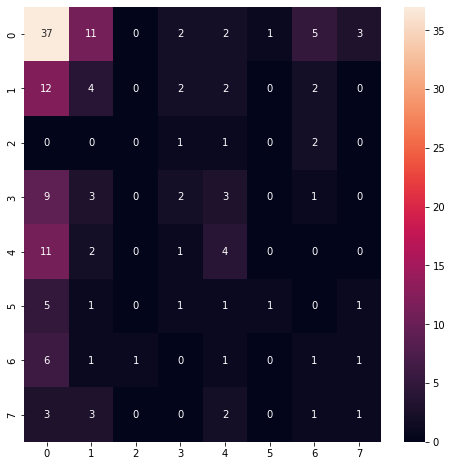

In [43]:
num_classes = 8
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(8)],
                  columns = [i for i in range(8)])
plt.figure(figsize = (8,8))
sns.heatmap(df_cm, annot=True)